In [2]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import os
great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = '/home/mpgetz/repos/bee_mapping/data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

# Define the bounding box
bbox = [-130, 25, -63, 54] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(1000))  # For approximately 1000 points
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

america_df = pd.DataFrame(land_coordinates, columns=['lat', 'lon'])

# america_df.to_csv('na_points2.csv', index=False)


In [3]:

from rasterio.warp import calculate_default_transform, reproject, Resampling

extent = [-131.53, -61.46, 24.09, 54.90]  # [min_lon, max_lon, min_lat, max_lat]

map_projection = ccrs.Mercator()  # Change to a suitable projection for your area


In [4]:

from rasterio.mask import mask

import geopandas as gpd

def clip_raster(raster_path, clip_extent, clipped_output_path):
    # Create a GeoDataFrame with the bounding box
    min_lon, max_lon, min_lat, max_lat = clip_extent
    bbox = box(min_lon, min_lat, max_lon, max_lat)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Clip the raster with the polygon and save the output
        out_image, out_transform = mask(src, geo.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rasterio.open(clipped_output_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [5]:
clip_raster('/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/NDVI_hires.tif', extent, 'data/wc2.1_30s_bio/clipped/NDVI_hires.tif')

In [6]:
from rasterio.enums import Resampling

def resample_raster(input_raster, output_raster, new_width, new_height):
    with rasterio.open(input_raster) as dataset:
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / new_width),
            (dataset.height / new_height)
        )

        data = dataset.read(
            out_shape=(
                dataset.count,
                new_height,
                new_width
            ),
            resampling=Resampling.bilinear  
        )

        new_meta = dataset.meta.copy()
        new_meta.update({
            "driver": "GTiff",
            "height": new_height,
            "width": new_width,
            "transform": transform
        })

        with rasterio.open(output_raster, "w", **new_meta) as dest:
            dest.write(data)

resample_raster('data/wc2.1_30s_bio/clipped/NDVI_hires.tif', 'data/wc2.1_30s_bio/clipped/NDVI_hires_resampled2.tif', 8409, 3698)


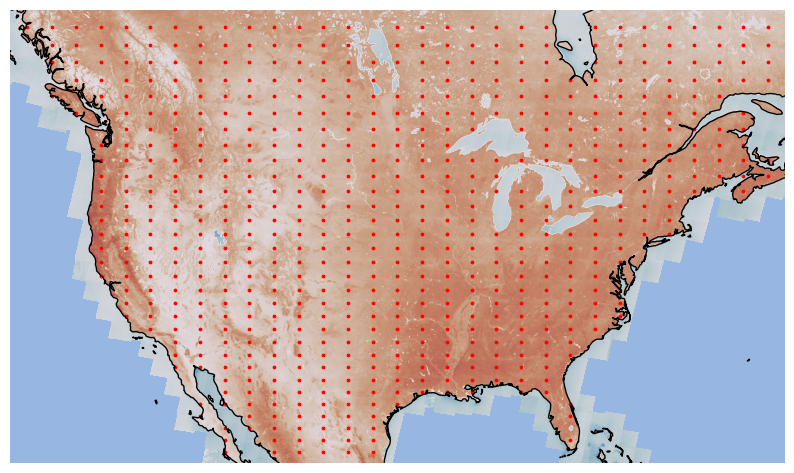

In [7]:
ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/clipped/NDVI_hires_resampled.tif'
with rasterio.open(ndvi_tiff_path) as ndvi_src:
    transform, width, height = calculate_default_transform(
        ndvi_src.crs, map_projection, ndvi_src.width, ndvi_src.height, *ndvi_src.bounds)
    ndvi_data = np.empty((height, width))
    reproject(
        source=rasterio.band(ndvi_src, 1),
        destination=ndvi_data,
        src_transform=ndvi_src.transform,
        src_crs=ndvi_src.crs,
        dst_transform=transform,
        dst_crs=map_projection,
        resampling=Resampling.nearest)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)

plt.imshow(ndvi_data, transform=map_projection, origin='upper', extent=ax.get_extent(), cmap='twilight_shifted', vmin=-1, vmax=1)

lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), color='red', s=3)

ax.axis('off')
plt.show()


In [14]:
dir = 'data/wc2.1_30s_bio/clipped'
tifs = os.listdir(dir)

for raster_file in tifs:
    with rasterio.open(os.path.join(dir,raster_file)) as src:
        print(f"CRS for {raster_file}: {src.crs}")
        print(src.shape)
        print(f"{raster_file}: {src.dtypes}")

CRS for wc2.1_30s_bio_11.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_11.tif: ('float32',)
CRS for wc2.1_30s_bio_3.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_3.tif: ('float32',)
CRS for wc2.1_30s_bio_9.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_9.tif: ('float32',)
CRS for wc2.1_30s_bio_13.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_13.tif: ('float32',)
CRS for wc2.1_30s_bio_5.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_5.tif: ('float32',)
CRS for wc2.1_30s_bio_6.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_6.tif: ('float32',)
CRS for wc2.1_30s_elev.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_elev.tif: ('int16',)
CRS for wc2.1_30s_bio_17.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_17.tif: ('float32',)
CRS for NDVI_hires_resampled_nodata.tif: EPSG:4326
(3698, 8409)
NDVI_hires_resampled_nodata.tif: ('float32',)
CRS for wc2.1_30s_bio_10.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_10.tif: ('float32',)
CRS for wc2.1_30s_bio_2.tif: EPSG:4326
(3698, 8409)
wc2.1_30s_bio_2.tif: ('float32',)
CRS for wc2.1_30s_bio_15.t

In [15]:
with rasterio.open('/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/clipped/wc2.1_30s_bio_1.tif') as src:
    nodata_value = src.nodata
    print(f"The 'no data' value is: {nodata_value}")

The 'no data' value is: -3.3999999521443642e+38


In [17]:
# with rasterio.open('/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/clipped/NDVI_hires_resampled.tif') as src:
#     # Assuming the problematic band is the first band
#     problematic_band = src.read(1)

#     # Replace NaN values with the 'no data' value
#     problematic_band = np.where(np.isnan(problematic_band), nodata_value, problematic_band)

#     # Prepare new metadata
#     new_meta = src.meta.copy()
#     new_meta.update({"nodata": nodata_value})

#     # Write the modified band back to a new file
#     with rasterio.open('/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/clipped/NDVI_hires_resampled_nodata.tif', 'w', **new_meta) as dest:
#         dest.write(problematic_band, 1)

# STACKING

In [11]:
from rasterio.merge import merge
from rasterio.plot import show
import glob

directory_path = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/clipped'


all_files = glob.glob(os.path.join(directory_path, '*.tif'))

datasets = [rasterio.open(file) for file in all_files]

stacked, out_trans = merge(datasets)

out_meta = datasets[0].meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": stacked.shape[1],
                 "width": stacked.shape[2],
                 "transform": out_trans,
                 "count": len(datasets)})

with rasterio.open('data/stacked.tif', "w", **out_meta) as dest:
    for i in range(stacked.shape[0]):  
        dest.write(stacked[i, :, :], i+1)  

In [18]:
band_data = []

# Read and append each band
for file in tifs:
    with rasterio.open(os.path.join(dir, file)) as src:
        band = src.read(1)  # Read the first band from each file
        band_data.append(band)

        # Optional: Check if NaNs are present in the band
        print(f"{file} - Contains NaNs: {np.isnan(band).any()}")

# Stack the bands
stacked = np.stack(band_data, axis=0)

# Check if NaNs are present in the stacked data
print(f"Stacked Data - Contains NaNs: {np.isnan(stacked).any()}")

wc2.1_30s_bio_11.tif - Contains NaNs: False
wc2.1_30s_bio_3.tif - Contains NaNs: False
wc2.1_30s_bio_9.tif - Contains NaNs: False
wc2.1_30s_bio_13.tif - Contains NaNs: False
wc2.1_30s_bio_5.tif - Contains NaNs: False
wc2.1_30s_bio_6.tif - Contains NaNs: False
wc2.1_30s_elev.tif - Contains NaNs: False
wc2.1_30s_bio_17.tif - Contains NaNs: False
NDVI_hires_resampled_nodata.tif - Contains NaNs: False
wc2.1_30s_bio_10.tif - Contains NaNs: False
wc2.1_30s_bio_2.tif - Contains NaNs: False
wc2.1_30s_bio_15.tif - Contains NaNs: False
wc2.1_30s_bio_12.tif - Contains NaNs: False
wc2.1_30s_bio_1.tif - Contains NaNs: False
wc2.1_30s_bio_16.tif - Contains NaNs: False
wc2.1_30s_bio_8.tif - Contains NaNs: False
wc2.1_30s_bio_4.tif - Contains NaNs: False
wc2.1_30s_bio_19.tif - Contains NaNs: False
wc2.1_30s_bio_7.tif - Contains NaNs: False
wc2.1_30s_bio_14.tif - Contains NaNs: False
wc2.1_30s_bio_18.tif - Contains NaNs: False
Stacked Data - Contains NaNs: False


In [20]:
file_path = 'data/stacked2.tif'
with rasterio.open(file_path) as src:
    print("Metadata of the TIFF file:")
    print(src.meta)
    print("Bounds:", src.bounds)
    print("CRS:", src.crs)
    # for i in range(src.count):
    #     data = src.read(i+1)
    #     print(f"Statistics for Band {i+1}:")
    #     print(f"Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, StdDev: {data.std()}")
    band1 = src.read(1)
    
    # Check if there are any non-NaN values
    if np.isnan(band1).any():
        print("Band 1 contains some NaN values.")
    else:
        print("Band 1 contains no NaN values.")

    # Optionally, print some statistics ignoring NaNs
    print("Statistics for Band 1 (ignoring NaNs):")
    print(f"Min: {np.nanmin(band1)}, Max: {np.nanmax(band1)}, Mean: {np.nanmean(band1)}, StdDev: {np.nanstd(band1)}")
    for i in range(2, src.count + 1):
        data = src.read(i)
        if np.isnan(data).any():
            print(f"Band {i} contains only NaNs.")
        else:
            print(f"Band {i} contains no NaNs.")

Metadata of the TIFF file:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 8409, 'height': 3698, 'count': 21, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -131.53333333333333,
       0.0, -0.008333333333333333, 54.9)}
Bounds: BoundingBox(left=-131.53333333333333, bottom=24.083333333333332, right=-61.45833333333333, top=54.9)
CRS: EPSG:4326
Band 1 contains no non-NaN values.
Statistics for Band 1 (ignoring NaNs):
Min: -3.3999999521443642e+38, Max: 22.933332443237305, Mean: -inf, StdDev: inf


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Band 2 contains no NaNs.
Band 3 contains no NaNs.
Band 4 contains no NaNs.
Band 5 contains no NaNs.
Band 6 contains no NaNs.
Band 7 contains no NaNs.
Band 8 contains no NaNs.
Band 9 contains no NaNs.
Band 10 contains no NaNs.
Band 11 contains no NaNs.
Band 12 contains no NaNs.
Band 13 contains no NaNs.
Band 14 contains no NaNs.
Band 15 contains no NaNs.
Band 16 contains no NaNs.
Band 17 contains no NaNs.
Band 18 contains no NaNs.
Band 19 contains no NaNs.
Band 20 contains no NaNs.
Band 21 contains no NaNs.


In [ ]:
with rasterio.open('/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/NDVI_hires.tif') as src:
    for i in range(1, src.count + 1):  # Loop through all bands
        band = src.read(i)

        # Check if there are NaN values in the band
        contains_nans = np.isnan(band).any()
        print(f"Band {i} contains NaN values: {contains_nans}")

Band 1 contains NaN values: True


In [19]:
with rasterio.open(os.path.join(dir, tifs[0])) as src:
    meta = src.meta.copy()
    all_bands = []

    for file in tifs:
        with rasterio.open(os.path.join(dir, file)) as src:
            band = src.read(1)  # Assuming each file has only one band
            all_bands.append(band)

    stacked = np.dstack(all_bands)  # Stack all bands

    # Update metadata for stacked raster
    meta.update({"count": stacked.shape[2], "height": stacked.shape[0], "width": stacked.shape[1]})

    # Write stacked raster to file
    with rasterio.open('data/stacked2.tif', "w", **meta) as dest:
        for i in range(stacked.shape[2]):
            dest.write(stacked[:, :, i], i+1)

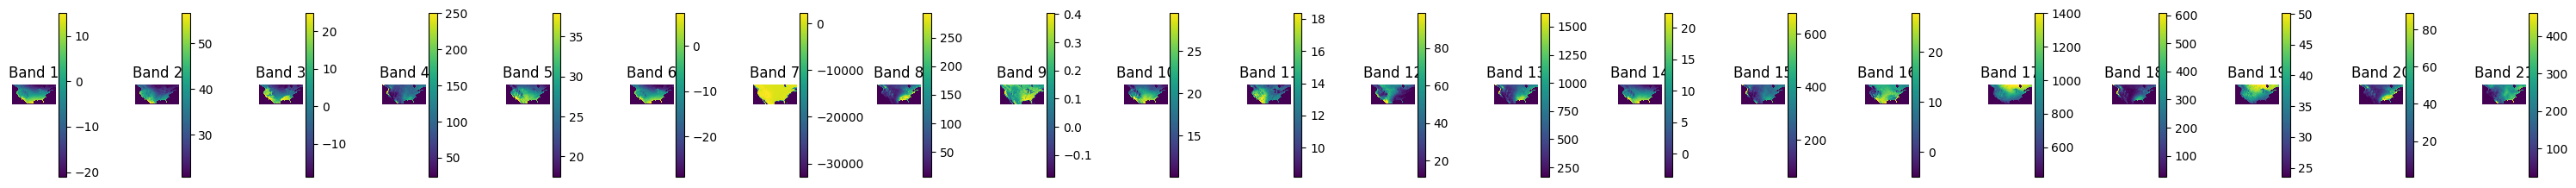

In [22]:
with rasterio.open('data/stacked2.tif') as src:
    fig, axs = plt.subplots(1, src.count, figsize=(30, 5))
    for i in range(src.count):
        data = src.read(i+1)

        # Calculate percentiles for robust color scaling
        vmin, vmax = np.percentile(data[data != src.nodata], [2, 98])  # Adjust the percentiles as needed

        ax = axs if src.count == 1 else axs[i]
        im = ax.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f"Band {i+1}")
        ax.axis('off')

        # Add colorbar for each subplot
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig('test.jpg')

In [24]:
from sklearn.decomposition import PCA

# Read the stacked raster
with rasterio.open('data/stacked2.tif') as src:
    # Read the raster data as a 3D array (bands, rows, columns)
    img = src.read()
    img = np.where(np.isinf(img), nodata_value, img)
    # Reshape to 2D array (pixels, bands)
    reshaped_img = img.reshape(-1, img.shape[0])

    # Perform PCA
    pca = PCA(n_components=3)  # Adjust n_components as needed
    transformed = pca.fit_transform(reshaped_img)

    # Reshape back to raster format (components, rows, columns)
    transformed_raster = transformed.reshape((transformed.shape[1], img.shape[1], img.shape[2]))

out_meta = src.meta
out_meta.update({"count": transformed_raster.shape[0]})

# Write the PCA output to a new file
with rasterio.open('data/pca_output.tif', "w", **out_meta) as dest:
    dest.write(transformed_raster)


: 